<a href="https://colab.research.google.com/github/tlysenko/ML-notebooks/blob/master/Breakfast_at_the_Frat_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Predicting the level of demand as High, Average or Low for the 'Breakfast at the Frat' dataset using Fbprophet for timeseries prediction { form-width: "100%" }

## Dataset: Breakfast at the Frat: A Time Series Analysis
https://www.dunnhumby.com/careers/engineering/sourcefiles



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

!pip install -U -q holidays
from datetime import date
import holidays


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Read data
file_id = '1Y64yxW5aoPqenfOlzBKfWzHZT08KI8zR'
file_prod = drive.CreateFile({'id': file_id})
file_prod.GetContentFile('products.csv')
dfproducts = pd.read_csv('products.csv')

file_id = '1_Ay4jCAjcZFA0E2hzdnOlAmU_KAIeh23'
file_prod = drive.CreateFile({'id': file_id})
file_prod.GetContentFile('store.csv')
dfstores = pd.read_csv('store.csv')

file_id = '1WvVwJQces3l3dh08GtMOkGrRvbAy0DUV'
file_prod = drive.CreateFile({'id': file_id})
file_prod.GetContentFile('transactions.csv')
dftransactions = pd.read_csv('transactions.csv')



In [0]:
# Libraries : prophet
from IPython.display import clear_output
try:
  !pip install pystan
  !pip install --upgrade git+https://github.com/jroakes/google-analytics.git
  !pip install fbprophet
except:
  pass
finally:
  clear_output()
  print('All Loaded')
  
from fbprophet import Prophet

All Loaded


In [0]:
# Data preparation
dftransactions.columns = [x.lower() for x in dftransactions.columns]
dfstores.columns = [x.lower() for x in dfstores.columns]
dfproducts.columns = [x.lower() for x in dfproducts.columns]

In [0]:
#@title Data Overview


In [0]:
dftransactions.head()

,week_end_date,store_num,upc,units,visits,hhs,spend,price,base_price,feature,display,tpr_only
0,14-Jan-09,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1
1,14-Jan-09,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0
2,14-Jan-09,367,1111009507,14,14,14,19.32,1.38,1.38,0,0,0
3,14-Jan-09,367,1111035398,4,3,3,14.00,3.50,4.49,0,0,1
4,14-Jan-09,367,1111038078,3,3,3,7.50,2.50,2.50,0,0,0


In [0]:
dfproducts.head()

,upc,description,manufacturer,category,sub_category,product_size
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111035398,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [0]:
dfstores.head()

,store_id,store_name,address_city_name,address_state_prov_code,msa_code,seg_value_name,parking_space_qty,sales_area_size_num,avg_weekly_baskets
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.80769
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.51923
2,4259,WARSAW AVENUE,CINCINNATI,OH,17140,VALUE,NaN,48813,31177.33333
3,6379,KINGWOOD,KINGWOOD,TX,26420,MAINSTREAM,NaN,50237,20620.42308
4,6431,AT WARD ROAD,BAYTOWN,TX,26420,VALUE,350.0,43698,24321.94231


In [0]:
#@title Building a function to predict the level of demand as High, Average or Low


In [0]:
def predict_units(perc, dfproducts, dftransactions,product_category = 'BAG SNACKS', store_id = 2277):
  # BAG SNACKS, FROZEN PIZZA, COLD CEREAL, ORAL HYGIENE PRODUCTS
  
  # selecting all upcs of the category
  upc_list = dfproducts[dfproducts.category == product_category].upc.unique()
  subdf = dftransactions[(dftransactions.upc.isin(upc_list))   & (dftransactions.store_num == store_id)].reset_index()
  

  # Data preparation
  subdf['week_end_date'] = pd.to_datetime(subdf.week_end_date, format = '%d-%b-%y' , infer_datetime_format=True)
  subdf = subdf.dropna(axis = 0)

  subdf = subdf.drop('index' , axis = 1)
  subdf = subdf.pivot_table(index='week_end_date', aggfunc = 'sum')
  
  subdf = subdf.reset_index()
 
  num_weeks_to_predict = 3
  X_test = subdf[ (subdf.week_end_date).isin((subdf.week_end_date.unique())[-num_weeks_to_predict:])][['week_end_date']]
  y_test = subdf[ (subdf.week_end_date).isin((subdf.week_end_date.unique())[-num_weeks_to_predict:])]['units']

  X_train = subdf[ (subdf.week_end_date).isin((subdf.week_end_date.unique())[:-num_weeks_to_predict])][['week_end_date']]
  y_train = subdf[ (subdf.week_end_date).isin((subdf.week_end_date.unique())[:-num_weeks_to_predict])]['units']
  
  
  # Adding HOLIDAYS
  us_holidays = holidays.UnitedStates()
  list_names = []
  list_dates = []
  for date, name in sorted(holidays.US(years=[2009, 2010,2011, 2012]).items()):
    if 'Observed' not in (name):
      list_names.append(name)
      list_dates.append(date)
  holidaysdf = pd.DataFrame({'ds': list_dates, 'holiday' : list_names, 'lower_window': -8,
  'upper_window': 8})

  # prepare df for Prophet
  prophet_df = pd.DataFrame({'ds': X_train.week_end_date , 'y': y_train})
  
  # remove outliers
  prophet_df.loc[ (prophet_df.y >= (np.percentile(prophet_df.y ,100-perc))) | (prophet_df.y <= (np.percentile(prophet_df.y , perc))) , 'y'  ]= None

  # setup Prophet
  model_pr = Prophet(holidays = holidaysdf)
  model_pr.add_seasonality(name='monthly', period=30.5, fourier_order=5)

  model_pr.fit(prophet_df)


  future = model_pr.make_future_dataframe(periods = num_weeks_to_predict, freq= '7d')
  units_forecast = model_pr.predict(future)
  
  lowb = np.percentile(prophet_df.y.dropna() , 25) 
  highb = np.percentile(prophet_df.y.dropna() , 75)
  
  int_low = [np.percentile(prophet_df.y.dropna() , 0), np.percentile(prophet_df.y.dropna() , 25)]
  int_avr = [np.percentile(prophet_df.y.dropna() , 25), np.percentile(prophet_df.y.dropna() , 75)]
  int_high = [np.percentile(prophet_df.y.dropna() , 76), np.percentile(prophet_df.y.dropna() , 100)]
  
   
  forecast_demand_level = ['low' if x < lowb else 'high' if x > highb else 'average' for x in units_forecast.yhat.tail(3)]
  actual_demand_level = ['low' if x < lowb else 'high' if x > highb else 'average' for x in prophet_df.y]

  forecast_data = units_forecast.yhat.tail(3)

  test_level = ['low' if x < lowb else 'high' if x > highb else 'average' for x in y_test]
  
  #forecast_level, test_level ,
  return  forecast_demand_level, test_level , units_forecast, y_test , model_pr
#forecast_level, test_level , units_forecast, y_test , model_pr 



In [0]:
#@title Building a confusion matrix per category to check the quality of prediction

In [0]:
categories_list =[ 'BAG SNACKS', 'FROZEN PIZZA', 'COLD CEREAL', 'ORAL HYGIENE PRODUCTS']
sumtrue = 0
delta_list = []
for cat in categories_list:
  ret_forecast_level, ret_test_level , ret_units_forecast, ret_y_true , ret_model_pr = predict_units(5,dfproducts, dftransactions,
                                                                                                       product_category = cat, store_id = 25233)
  
  print('Category: ' , cat)
  print('Confusion matrix: ')
  print(pd.DataFrame(confusion_matrix(ret_test_level, ret_forecast_level, labels = ['low' ,  'average' , 'high']) , 
             columns = ['Low' ,  'Average' , 'High'], 
            index = ['Low' ,  'Averae' , 'High']))
  
  sumtrue = sumtrue + sum([x==y for x,y in zip(ret_forecast_level , ret_test_level)])
  delta_list.extend((( (ret_y_true - ret_units_forecast.yhat.tail(3)) / ret_y_true)*100).values)

print('SCORE: 12/' , sumtrue)
  

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Category:  BAG SNACKS
Confusion matrix: 
        Low  Average  High
Low       0        0     0
Averae    0        0     1
High      0        0     2


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Category:  FROZEN PIZZA
Confusion matrix: 
        Low  Average  High
Low       0        0     1
Averae    0        0     1
High      0        0     1


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Category:  COLD CEREAL
Confusion matrix: 
        Low  Average  High
Low       0        0     1
Averae    0        0     1
High      0        0     1
Category:  ORAL HYGIENE PRODUCTS
Confusion matrix: 
        Low  Average  High
Low       1        0     0
Averae    1        1     0
High      0        0     0
SCORE: 12/ 6


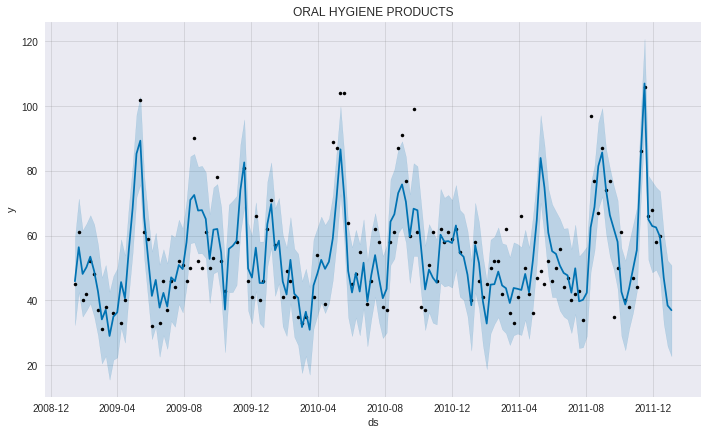

In [0]:
ret_model_pr.plot(ret_units_forecast)
plt.title(cat);

ORAL HYGIENE PRODUCTS


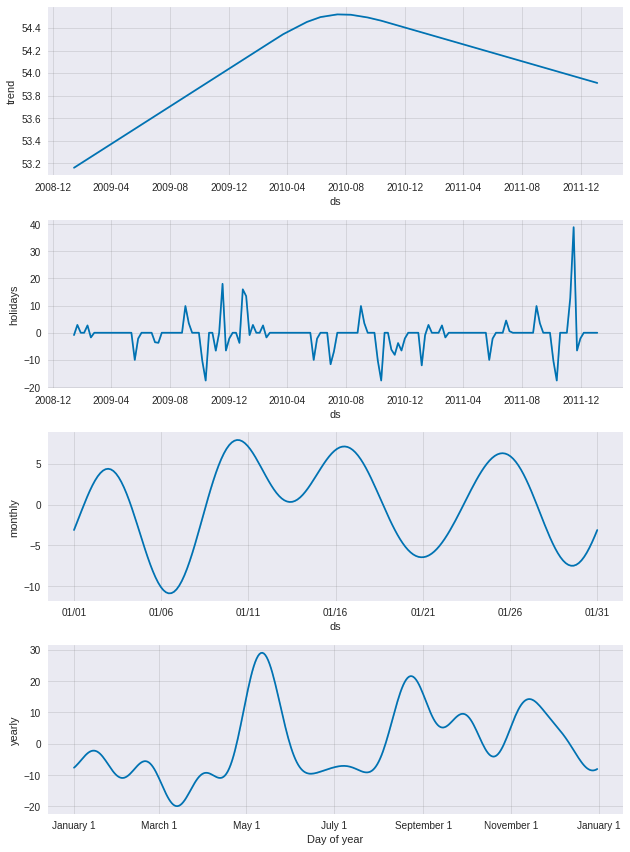

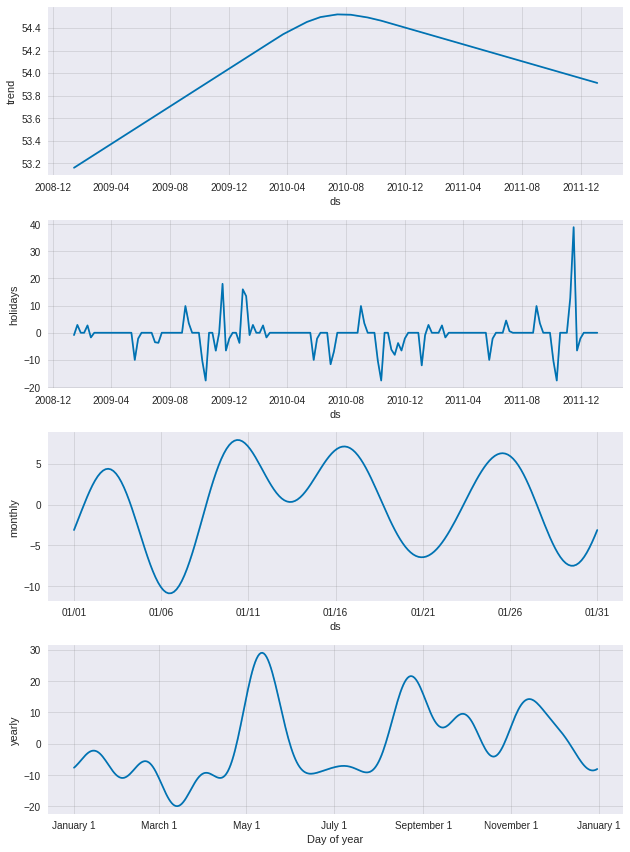

In [0]:
print(cat);
ret_model_pr.plot_components(ret_units_forecast)